In [1]:
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np
import random
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Trainer, GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup, TrainingArguments, DataCollatorForLanguageModeling
from tqdm import tqdm, trange
import torch.nn.functional as F
import csv
import pickle
import string
import matplotlib.pyplot as plt
import re
from collections import Counter

In [2]:
msg_from_ex = pickle.load(open("/Users/bayesiandater/ex_bot/resources/msg_from_ex", "rb"))
msg_from_ex = [m.lower() for m in msg_from_ex if m.strip() != ""]

In [3]:
rng = np.random.default_rng(713)
train_idx = rng.integers(low=0, high=len(msg_from_ex), size=int(0.8 * len(msg_from_ex)))
valid_idx = [i for i in range(len(msg_from_ex)) if i not in train_idx]
train_ls, valid_ls = np.array(msg_from_ex)[train_idx], np.array(msg_from_ex)[valid_idx]

#### decide on the number of sentence length to feed into the model

(array([54., 27., 24., 14.,  3.,  3.,  0.,  1.,  0.,  1.]),
 array([ 1. ,  3.1,  5.2,  7.3,  9.4, 11.5, 13.6, 15.7, 17.8, 19.9, 22. ]),
 <BarContainer object of 10 artists>)

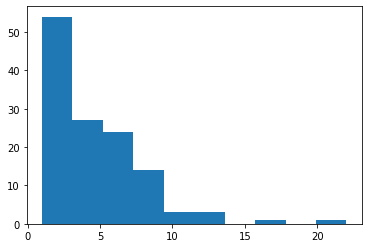

In [4]:
plt.hist([len(m.strip().split()) for m in train_ls])

In [5]:
# get the custom tokens to add to tokenizer
# get the GPT2 token list
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

GPT2_tokens = []
for w in tokenizer.encoder.keys():
    w = w.strip("Ġ").lower()
    GPT2_tokens.append(w)
    
# only add all whole words from both train + valid sets 
# that are not in the original GPT2 tokenizer's vocabulary 15
all_words = []
for m in msg_from_ex:
    m = m.strip(string.punctuation).lower().split()
    all_words += m

added_tokens = []
for word, freq in Counter(all_words).most_common():
    if word not in GPT2_tokens:
        added_tokens.append(word)
        
del tokenizer

In [6]:
class MSG(Dataset):  
    def __init__(self, ls_stc, truncate=False, gpt2_type="gpt2", max_length=1024, added_tokens=None):

        self.tokenizer = GPT2Tokenizer.from_pretrained(gpt2_type)
        special_tokens = {'pad_token':'<|pad|>','sep_token':'<|sep|>'}
        self.tokenizer.add_special_tokens(special_tokens)
        if added_tokens is not None:
            self.tokenizer.add_tokens(added_tokens)
        self.msgs = []
        max_len = 0
        
        for m in ls_stc:
            m = torch.tensor(
                self.tokenizer.encode(self.tokenizer.bos_token + f"{m[:max_length]}" + self.tokenizer.eos_token, \
                                      max_length=15, padding="max_length", truncation=True))
            max_len = max(len(m), max_len)

            self.msgs.append(m)
        
        if truncate:
            self.msgs = self.msgs[:20000]
            
        self.msgs_count = len(self.msgs)
        
    def __len__(self):
        return self.msgs_count

    def __getitem__(self, item):
        return self.msgs[item]
    


In [7]:
ds_base_train = MSG(train_ls, truncate=True, gpt2_type="gpt2", added_tokens=None)  
ds_base_valid = MSG(valid_ls, truncate=True, gpt2_type="gpt2", added_tokens=None) 

In [8]:
data_collator = DataCollatorForLanguageModeling(
        tokenizer=ds_base_train.tokenizer,
        mlm=False
    )

In [9]:
training_args = TrainingArguments(
    output_dir="/Users/bayesiandater/ex_bot",          # output directory
    num_train_epochs=6,              # total # of training epochs
    per_device_train_batch_size=10,  # batch size per device during training
    per_device_eval_batch_size=10,   # batch size for evaluation
    warmup_steps=200,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    prediction_loss_only=True,
    save_steps=1000 
)

In [10]:
device= "gpu" if torch.cuda.is_available() else "cpu"

model_base = GPT2LMHeadModel.from_pretrained('gpt2')
model_base.resize_token_embeddings(len(ds_base_train.tokenizer))
model_base = model_base.to(device)

In [ ]:
trainer = Trainer(
    model=model_base,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    data_collator=data_collator,
    train_dataset=ds_base_train,         # training dataset
    eval_dataset=ds_base_valid            # evaluation dataset
)

trainer.train()

In [12]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 71
  Batch size = 10


{'eval_loss': 5.627530574798584,
 'eval_runtime': 1.0273,
 'eval_samples_per_second': 69.111,
 'eval_steps_per_second': 7.787,
 'epoch': 6.0}

### 1. beam search 

In [16]:
max_length = 50 
num_beams=20
num_return_sequences= 20
early_stopping= False
no_repeat_ngram_size=2
total = []

for j, m in enumerate(ds_base_valid):
    ops = model_base.generate(m[:3].unsqueeze(0), 
                                max_length = max_length,
                               num_beams=num_beams,
                                num_return_sequences=num_return_sequences,
                                no_repeat_ngram_size=no_repeat_ngram_size,
                                early_stopping=early_stopping)
    
    for i, beam in enumerate(ops):
        o = ds_base_train.tokenizer.decode(beam, skip_special_tokens=True)
        o = re.sub(r"[ +|\n]", " ", o).strip("\n ")
        o = re.sub(r" +", " ", o).strip("\n ")
        if o not in ["",  " "]:
            print(o)
            total.append(o)
            
    if j == 1:
        break

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


i love it
i love it
i love it when people tell me what to do
i love it i can't wait to see you
i love it when people tell me what to do
i love it when you dont know what to make of it
i love it when you dont know what to make of it
i love it i can't wait to see what you guys think
i love it i can't wait to see what you've got in store for me
i love it i can't wait to see what you've got
i love it when you dont know what to make
i love it when you can't wait to see what else you've got on your mind
i love it when you can't wait to see what else you've got on your mind
i love it i can't wait to see what you think about this
i love it i can't wait to see what you guys think about
i love it i can't wait to see what you guys think about it
i love it i can't wait to see what you guys think about this
i love it i can't wait to see what you think about
i love this post
i love it when you can't wait to see what else is happening in the world
all water
all water
all water
all water
all watercool

### 2. sampling

In [20]:
max_length = 100
num_beams=20
num_return_sequences= 20
early_stopping=True 
no_repeat_ngram_size=2
do_sample = True
total = []

for j, m in enumerate(ds_base_valid):
    ops = model_base.generate(m[:3].unsqueeze(0), 
                                max_length = max_length,
                                do_sample=do_sample,
                                num_return_sequences=num_return_sequences,
                                no_repeat_ngram_size=no_repeat_ngram_size,
                                early_stopping=early_stopping)
    
    for i, beam in enumerate(ops):
        o = ds_base_train.tokenizer.decode(beam, skip_special_tokens=True)
        o = re.sub(r"[ +|\n]", " ", o).strip("\n ")
        o = re.sub(r" +", " ", o).strip("\n ")
        if o not in ["",  " "]:
            print(o)
            total.append(o)
            
    if j == 1:
        break

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


i love when i am the happiest i have the coolest
i love what you are doing
i love this i cant wait to see what you will cook it
i love it
i love it ❤
i love a guest Jan
i love
i love the way it was meant to be so let you know
i love the colors of this thread its like it, it came in a very humid
i love this dude y
i love the best
i love, love your stuff michael klobben
i love when they did what they do now
i love watching wat is on
i love red velvet
i love thats
i love these lil thingies
i love it but it is free
i love i am
i love it
all water
all water
all water
all water
all water
all water
all water, air, rain
all water
all water
all water for life is in the words
all watercool is
all watermelon strawberry sundae
all water buffalo
all water
all water
all watercourses
all water
all waterfalls sky
all water, all air, fire, rain. The world is based on
all water


In [18]:
max_length = 100
num_beams=20
num_return_sequences= 20
early_stopping=False 
no_repeat_ngram_size=2
do_sample = True
total = []

for j, m in enumerate(ds_base_valid):
    ops = model_base.generate(m[:3].unsqueeze(0), 
                                max_length = max_length,
                                do_sample=do_sample,
                                num_return_sequences=num_return_sequences,
                                no_repeat_ngram_size=no_repeat_ngram_size,
                                early_stopping=early_stopping)
    
    for i, beam in enumerate(ops):
        o = ds_base_train.tokenizer.decode(beam, skip_special_tokens=True)
        o = re.sub(r"[ +|\n]", " ", o).strip("\n ")
        o = re.sub(r" +", " ", o).strip("\n ")
        if o not in ["",  " "]:
            print(o)
            total.append(o)
            
    if j == 1:
        break

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


i love this guy, im sure i have met your mom last night
i love these guys i mean wanna know about and they dont give a fuck about dont have a dick nobody
i love it when people ask me to do sexy pictures but i dont think so
i love sucking dick
i love this review
i love this i canadian and they hate their own country
i love watching
i love what i see in these images and is happening
i love it
i love this article
i love goodreads, but then i am also a huge sarahandrew
i love
i love watching it
i love this game no it is just some simple love it
i love this song
i love when they have free will or if you are fat
i love reddit.com so much
i love
i love it but i am going to bed
i love sweet
all water this is a very bad smell
all water
all water and dust
all water
all watercolour
all water
all water, humidity, winter
all water, salmonella, papaya, rosemary
all water
all water
all water
all water
all water now i guess but i just got to get in contact with some of your fav animals
all water
all w

In [13]:
max_length = 100
num_beams=10
num_return_sequences= 10
early_stopping=True 
no_repeat_ngram_size=2
do_sample = True
temperature=0.9
top_k = 30
total = []

for j, m in enumerate(ds_base_valid):
    ops = model_base.generate(m[:5].unsqueeze(0), 
                                max_length = max_length,
                                do_sample=do_sample,
                                num_return_sequences=num_return_sequences,
                                no_repeat_ngram_size=no_repeat_ngram_size,
                                top_k = top_k,
                                temperature=temperature,
                                early_stopping=early_stopping)
    
    for i, beam in enumerate(ops):
        o = ds_base_train.tokenizer.decode(beam, skip_special_tokens=True)
        o = re.sub(r"[ +|\n]", " ", o).strip("\n ")
        o = re.sub(r" +", " ", o).strip("\n ")
        if o not in ["",  " "]:
            print(o)
            total.append(o)
            
    if j == 1:
        break

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


i love itIn the
i love itImage caption when i feel like it
i love itThis story first aired in
i love itA man
i love itI
i love it"When we
i love itAbout
i love itBANGKOK (Reuters)
i love itDescription Welcome to the perfect
i love itWe
all water under the stars
all water under the sun (including sunrays)
all water under the sun is fine
all water under the sun
all water under the table
all water under the sun
all water under the brook
all water under the sun
all water under the table
all water under the table


In [14]:
max_length = 100
num_beams=10
num_return_sequences= 10
early_stopping=False
no_repeat_ngram_size=2
do_sample = True
temperature=0.9
top_k = 50
total = []

for j, m in enumerate(ds_base_valid):
    ops = model_base.generate(m[:5].unsqueeze(0), 
                                max_length = max_length,
                                do_sample=do_sample,
                                num_return_sequences=num_return_sequences,
                                no_repeat_ngram_size=no_repeat_ngram_size,
                                top_k = top_k,
                                temperature=temperature,
                                early_stopping=early_stopping)
    
    for i, beam in enumerate(ops):
        o = ds_base_train.tokenizer.decode(beam, skip_special_tokens=True)
        o = re.sub(r"[ +|\n]", " ", o).strip("\n ")
        o = re.sub(r" +", " ", o).strip("\n ")
        if o not in ["",  " "]:
            print(o)
            total.append(o)
            
    if j == 1:
        break

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


i love itAbstract
i love itA new anis
i love itAs
i love itPredictably, was the
i love it(Reuters)
i love itShare This The latest for me, a
i love itGet daily updates directly
i love itFor
i love itA lot of
i love itAnthropologists
all water under the bed
all water under the sun
all water under the sun
all water under the sun
all water under the sun but i want to know what are these
all water under the sun
all water under the broiler
all water under the moon
all water under the brook
all water under the sun hottest oil


In [15]:
max_length = 100
num_beams=10
num_return_sequences= 10
early_stopping=False
no_repeat_ngram_size=2
do_sample = True
temperature=0.9
top_k = 50
total = []

for j, m in enumerate(ds_base_valid):
    ops = model_base.generate(m[:5].unsqueeze(0), 
                                max_length = max_length,
                                do_sample=do_sample,
                                num_return_sequences=num_return_sequences,
                                no_repeat_ngram_size=no_repeat_ngram_size,
                                top_k = top_k,
                                temperature=temperature,
                                early_stopping=early_stopping)
    
    for i, beam in enumerate(ops):
        o = ds_base_train.tokenizer.decode(beam, skip_special_tokens=True)
        o = re.sub(r"[ +|\n]", " ", o).strip("\n ")
        o = re.sub(r" +", " ", o).strip("\n ")
        if o not in ["",  " "]:
            print(o)
            total.append(o)
            
    if j == 1:
        break

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


i love itDescription: videos
i love itI
i love itFor it's hottest stories in science news, check out our newest addition to the science and technology
i love itThe Last Days of the
i love itWhen Michael.k.a. Michael Douglas is an actor and producer famous for his
i love itAnchor of fire is great
i love itThis article is. It's based onand well behaved
i love itPresident Obama has
i love itThe US economy
i love itCrowdStrike
all water under the sun
all water under the sun. Please do not put cookies.
all water under the sun
all water under the hood
all water under the brook
all water under the sun in dry weather
all water under the title The Wet Nurse
all water under the bed
all water under the moon
all water under the influence of alcohol if you are feeling really
